In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Libraries

In [2]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2
!pip install "gym[atari, accept-rom-license]"

In [3]:
import gym
import cv2
import math
import random
import warnings
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from colabgymrender.recorder import Recorder


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

  from scipy.ndimage.filters import sobel



In [4]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  and should_run_async(code)



# Sum tree

In [5]:
class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.n_entries = 0

    # Update to the root node
    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    # Find experience on leaf node
    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]

    # Store priority and experience
    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1

    # Update priority
    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    # Get priority and sample
    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])

# Prioritized Replay Memory

In [6]:
class PrioritizedReplayMemory():
    def __init__(self, max_size, min_replay_size):
        # Making the tree
        self.max_size = max_size
        self.min_replay_size = min_replay_size
        self.tree = SumTree(self.max_size)

        # Hyperparameters
        self.e = 0.0001
        self.a = 0.7
        self.beta = 0.5

        self.beta_increment_per_sampling = 0.000001

    def get_priority(self, error):
        # Compute priority
        return abs(error + self.e) ** self.a

    def add(self, experience, q_net, target_net, gamma):
        # Unpack
        state, action, reward, done, next_state = experience
        state = preprocess(state) # resize and convert to gray scale
        next_state = preprocess(next_state) # resize and convert to gray scale

        # Convert state and next_state to tensor
        state = torch.tensor(state, dtype=torch.float32).to(device)
        next_state = torch.tensor(next_state, dtype=torch.float32).to(device)
        action_temp = torch.tensor([[int(action)]], dtype=torch.int64).to(device)
        # Prediction
        q_values = q_net(state.unsqueeze(0))

        action_q_value = torch.gather(input=q_values, dim=1, index=action_temp)

        # Target
        target_q_value = target_net(next_state.unsqueeze(0))
        max_target_q_value = target_q_value.gather(
            1, q_net(next_state.unsqueeze(0)).argmax(dim=1, keepdim=True)
        )

        target = reward + gamma * (1 - done) * max_target_q_value

        # Computre error
        error = torch.abs(action_q_value - target).data.cpu().numpy()

        # Computre priority
        priority = self.get_priority(error)

        # Add to tree
        experience = (state, int(action), reward, done, next_state)
        self.tree.add(priority, experience)

    def get_batch(self, batch_size):
        batch = []
        idxs = []
        segment = self.tree.total() / batch_size
        priorities = []

        self.beta = np.min([1. - self.e, self.beta + self.beta_increment_per_sampling])

        for i in range(batch_size):
            a = segment * i
            b = segment * (i + 1)
            while True:
                s = random.uniform(a, b)
                (idx, p, data) = self.tree.get(s)
                if not isinstance(data, int):
                    break
            priorities.append(p)
            batch.append(data)
            idxs.append(idx)

        sampling_probabilities = priorities / self.tree.total()
        is_weight = np.power(self.tree.n_entries * sampling_probabilities, -self.beta)
        is_weight /= is_weight.max()

        # Take batches from experiences
        states = np.array([experience[0].data.cpu().numpy() for experience in batch])
        actions = np.array([experience[1] for experience in batch])
        rewards = np.array([experience[2] for experience in batch])
        dones = np.array([experience[3] for experience in batch])
        next_states = np.array([experience[4].data.cpu().numpy() for experience in batch])

        # Convert to tensor
        states = torch.tensor(states, dtype=torch.float32).to(device)
        actions = torch.tensor(actions, dtype=torch.int64).to(device).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        dones = torch.tensor(dones, dtype=torch.float32).to(device).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(device)

        return states, actions, rewards, dones, next_states, idxs, is_weight

    def update(self, idx, error):
        priority = self.get_priority(error)
        self.tree.update(idx, priority)

# Normal Replay Memory

In [7]:
class NormalReplayMemory():
    def __init__(self, max_size, min_replay_size):
        self.max_size = max_size
        self.memory = deque(maxlen=self.max_size)
        self.min_replay_size = min_replay_size

    def add(self, experience):
        state, action, reward, done, next_state = experience
        state = preprocess(state) # resize and convert to gray scale
        next_state = preprocess(next_state) # resize and convert to gray scale
        experience = (state, action, reward, done, next_state)
        self.memory.append(experience)

    def get_batch(self, batch_size):
        experiences = random.sample(self.memory, batch_size)

        # Take batches from experiences
        states = np.array([experience[0] for experience in experiences])
        actions = np.array([experience[1] for experience in experiences])
        rewards = np.array([experience[2] for experience in experiences])
        dones = np.array([experience[3] for experience in experiences])
        next_states = np.array([experience[4] for experience in experiences])

        # Convert to tensor
        states = torch.tensor(states, dtype=torch.float32).to(device)
        actions = torch.tensor(actions, dtype=torch.int64).to(device).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        dones = torch.tensor(dones, dtype=torch.float32).to(device).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(device)

        return states, actions, rewards, dones, next_states


# Utils

In [8]:
def preprocess(state):
    state = cv2.cvtColor(state, cv2.COLOR_RGB2GRAY)
    state_resize = cv2.resize(state, (84, 84), interpolation=cv2.INTER_CUBIC)
    state_resize = np.reshape(state_resize, (1, 84, 84))

    return state_resize

In [9]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


# Network

In [10]:
class NeuronNetwork(nn.Module):
    def __init__(self, env):
        super(NeuronNetwork, self).__init__()
        self.network = nn.Sequential(
            # Extraction
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Prediction
            nn.Flatten(),
            nn.Linear(in_features=11552, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=env.action_space.n)
        )

    def forward(self, state):
        x = self.network(state)
        return x

    def choose_action(self, state):
        # Compute max q value
        state = preprocess(state)
        state = torch.tensor(state, dtype=torch.float32).to(device)
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().cpu().numpy()

# Agent

In [11]:
class Agent():
    def __init__(self, env, MEMORY_TYPE, max_epsilon, min_epsilon, max_num_steps, \
                 epsilon_decay_intervals, gamma, alpha, \
                 memory_size, min_replay_size, batch_size, \
                 target_update_frequency):
        # Environment
        self.env = env
        self.MEMORY_TYPE = MEMORY_TYPE
        # Memory replay
        if MEMORY_TYPE == "Prioritized":
            self.memory = PrioritizedReplayMemory(max_size=memory_size, min_replay_size=min_replay_size)
        else:
            self.memory = NormalReplayMemory(max_size=memory_size, min_replay_size=min_replay_size)

        # Hyperparameters
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.max_num_steps = max_num_steps
        self.epsilon_decay_intervals = epsilon_decay_intervals
        self.gamma = gamma # discount value
        self.alpha = alpha # learning rate
        self.batch_size = batch_size # batch size taken from memory
        self.target_update_frequency = target_update_frequency # target network update frequency

        # Network
        self.q_net = NeuronNetwork(self.env).to(device)
        self.q_net.apply(init_weights)

        self.target_net = NeuronNetwork(self.env).to(device)

        self.target_net.load_state_dict(self.q_net.state_dict())

        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=self.alpha)

    def choose_action(self, epsilon, state):
        random_number = np.random.uniform(0,1)
        if random_number <= epsilon:
            action = self.env.action_space.sample()
        else:
            action = self.q_net.choose_action(state)
        return action

    def fill_memory(self):
        state = self.env.reset()

        # Loop min_replay_size times and append experience to memory
        for _ in range(self.memory.min_replay_size):

            # Randomly taking action
            action = self.env.action_space.sample()

            next_state, reward, done, info = self.env.step(action)
            experience = (state, action, reward, done, next_state)

            # Add to memory
            if self.MEMORY_TYPE == "Prioritized":
                self.memory.add(experience, self.q_net, self.target_net, self.gamma)
            else:
                self.memory.add(experience)

            state = next_state

            if done:
                self.env.reset()

    def training(self):
        # Fill memory
        self.fill_memory()
        reward_buffer = deque(maxlen=100) # Rewards of the previous 100 episodes

        reward_per_episode = 0.0
        state = self.env.reset()
        all_rewards = []

        for step in range(self.max_num_steps):
            # Computer epsilon
            epsilon = np.interp(step, [0, self.epsilon_decay_intervals], [self.max_epsilon, self.min_epsilon])
            # Choose action to take
            action = self.choose_action(epsilon, state)

            # Take action and add experience to memory
            next_state, reward, done, info = self.env.step(action)
            experience = (state, action, reward, done, next_state)
            # Add to memory
            if self.MEMORY_TYPE == "Prioritized":
                self.memory.add(experience, self.q_net, self.target_net, self.gamma)
            else:
                self.memory.add(experience)

            reward_per_episode += reward

            state = next_state

            # If done, 1 episode is done
            if done:
                state = self.env.reset()
                reward_buffer.append(reward_per_episode)
                all_rewards.append((step, reward_per_episode))
                reward_per_episode = 0.0

            # Get batch from memory for training
            if self.MEMORY_TYPE == "Prioritized":
                states, actions, rewards, dones, next_states, idxs, is_weights = self.memory.get_batch(self.batch_size)
            else:
                states, actions, rewards, dones, next_states = self.memory.get_batch(self.batch_size)



            # Predict Q value with Q network
            q_values = self.q_net(states)
            action_q_values = torch.gather(input=q_values, dim=1, index=actions)

            # Predict target with Target network

            ## DQN
            # target_q_values = self.target_net(next_states)
            # max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]

            ## DDQN
            target_q_values = self.target_net(next_states)
            max_target_q_values = target_q_values.gather(
                1, self.q_net(next_states).argmax(dim=1, keepdim=True)
            )

            targets = rewards + self.gamma * (1 - dones) * max_target_q_values


            # Compute loss
            if self.MEMORY_TYPE == "Prioritized":
                loss = torch.tensor(is_weights, dtype=torch.float32).to(device) * torch.nn.functional.mse_loss(action_q_values, targets)
                loss = loss.mean()
                # Update priority
                errors = torch.abs(action_q_values - targets)
                for i in range(self.batch_size):
                    idx = idxs[i]
                    self.memory.update(idx, errors[i])
            else:
                loss = torch.nn.functional.mse_loss(action_q_values, targets)



            # Gradient descent for q-network
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Update target network
            if (step + 1) % self.target_update_frequency == 0:
                self.target_net.load_state_dict(self.q_net.state_dict())

            # Print training results
            if (step + 1) % 1000 == 0:
                average_reward = np.mean(reward_buffer)
                print(f'Episode: {len(all_rewards)} Step: {step+1} Average reward: {average_reward}')
        return all_rewards

# Run

In [12]:
# Hyperparameters
max_epsilon = 1.0
min_epsilon = 0.01
max_num_steps = 200000
epsilon_decay_intervals = 50000
gamma = 0.99 # discount
alpha = 5e-4 # learning rate

# Memory
memory_size = 20000
min_replay_size = 1000
batch_size = 32

target_update_frequency = 1000 # target network update frequency


In [ ]:
env = gym.make("ALE/KungFuMaster-v5")
model = Agent(env, "Prioritized", max_epsilon, min_epsilon, max_num_steps, \
                 epsilon_decay_intervals, gamma, alpha, \
                 memory_size, min_replay_size, batch_size, \
                 target_update_frequency)
all_rewards = model.training()

Episode: 1 Step: 1000 Average reward: 300.0
Episode: 2 Step: 2000 Average reward: 400.0
Episode: 3 Step: 3000 Average reward: 366.6666666666667
Episode: 4 Step: 4000 Average reward: 425.0
Episode: 5 Step: 5000 Average reward: 500.0
Episode: 6 Step: 6000 Average reward: 483.3333333333333
Episode: 7 Step: 7000 Average reward: 514.2857142857143
Episode: 8 Step: 8000 Average reward: 600.0
Episode: 9 Step: 9000 Average reward: 611.1111111111111
Episode: 10 Step: 10000 Average reward: 600.0
Episode: 11 Step: 11000 Average reward: 590.9090909090909
Episode: 12 Step: 12000 Average reward: 583.3333333333334
Episode: 14 Step: 13000 Average reward: 542.8571428571429
Episode: 15 Step: 14000 Average reward: 560.0
Episode: 16 Step: 15000 Average reward: 562.5
Episode: 17 Step: 16000 Average reward: 600.0
Episode: 17 Step: 17000 Average reward: 600.0
Episode: 19 Step: 18000 Average reward: 663.1578947368421
Episode: 20 Step: 19000 Average reward: 680.0
Episode: 21 Step: 20000 Average reward: 690.4761

In [ ]:
# torch.save(model.q_net, '/content/drive/MyDrive/RL/Report/DDQN/model_v3.pth')
# np.save('/content/drive/MyDrive/RL/Report/DDQN/all_rewards_v3', all_rewards)

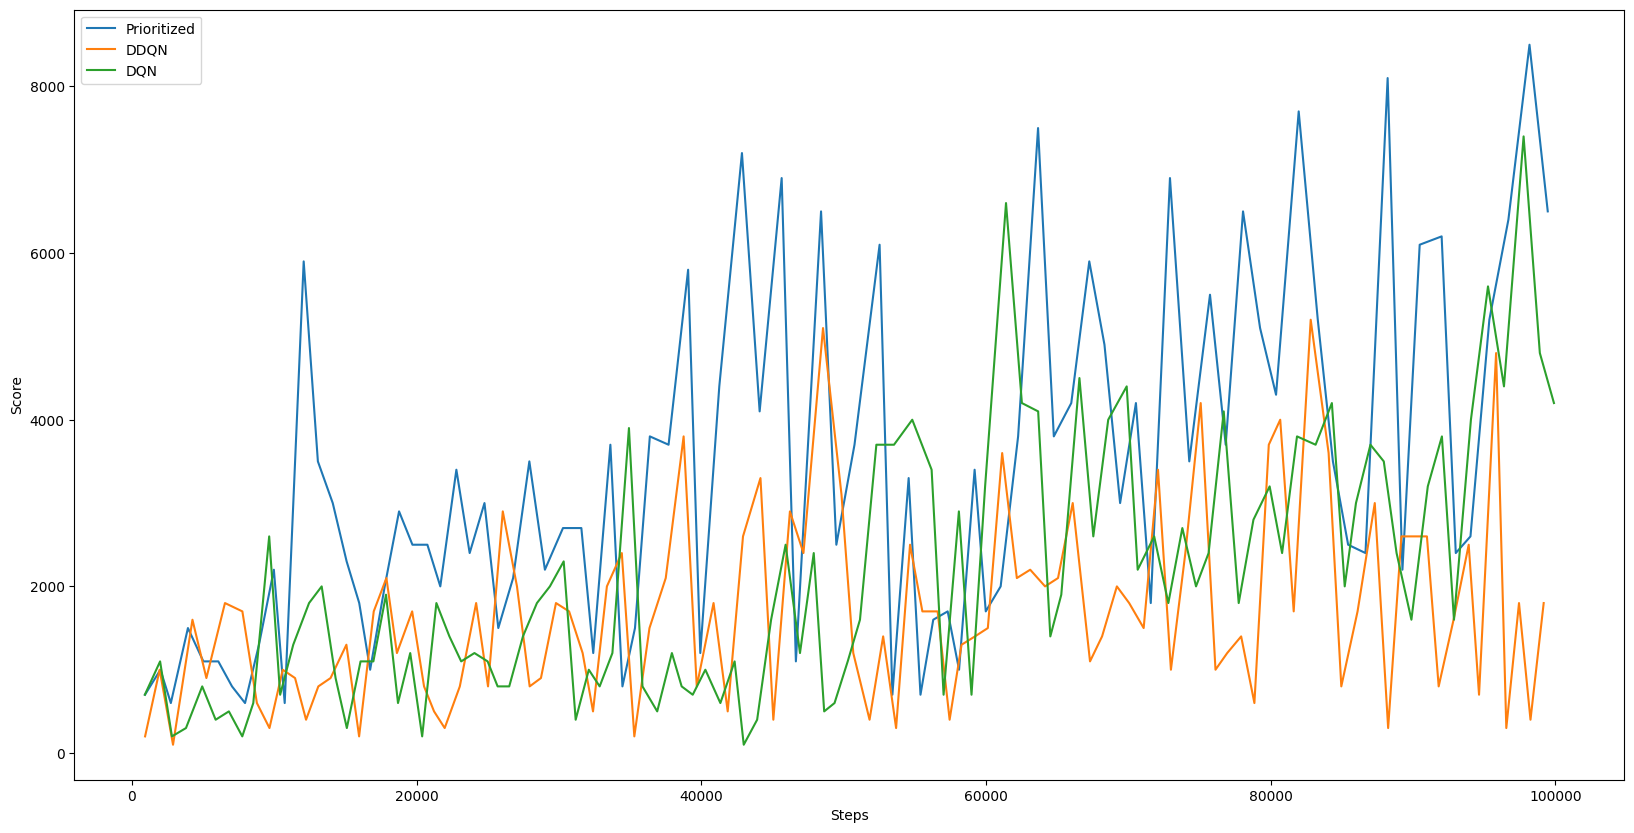

In [ ]:
rewards1 = np.load('/content/drive/MyDrive/RL/Report/Prioritized DDQN/all_rewards.npy')
rewards2 = np.load('/content/drive/MyDrive/RL/Report/DDQN/all_rewards.npy')
rewards3 = np.load('/content/drive/MyDrive/RL/Report/DQN/all_rewards.npy')
plt.figure(figsize=(20,10))
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(rewards1[:, 0], rewards1[:, 1], label='Prioritized')
plt.plot(rewards2[:, 0], rewards2[:, 1], label='DDQN')
plt.plot(rewards3[:, 0], rewards3[:, 1], label='DQN')
plt.legend()

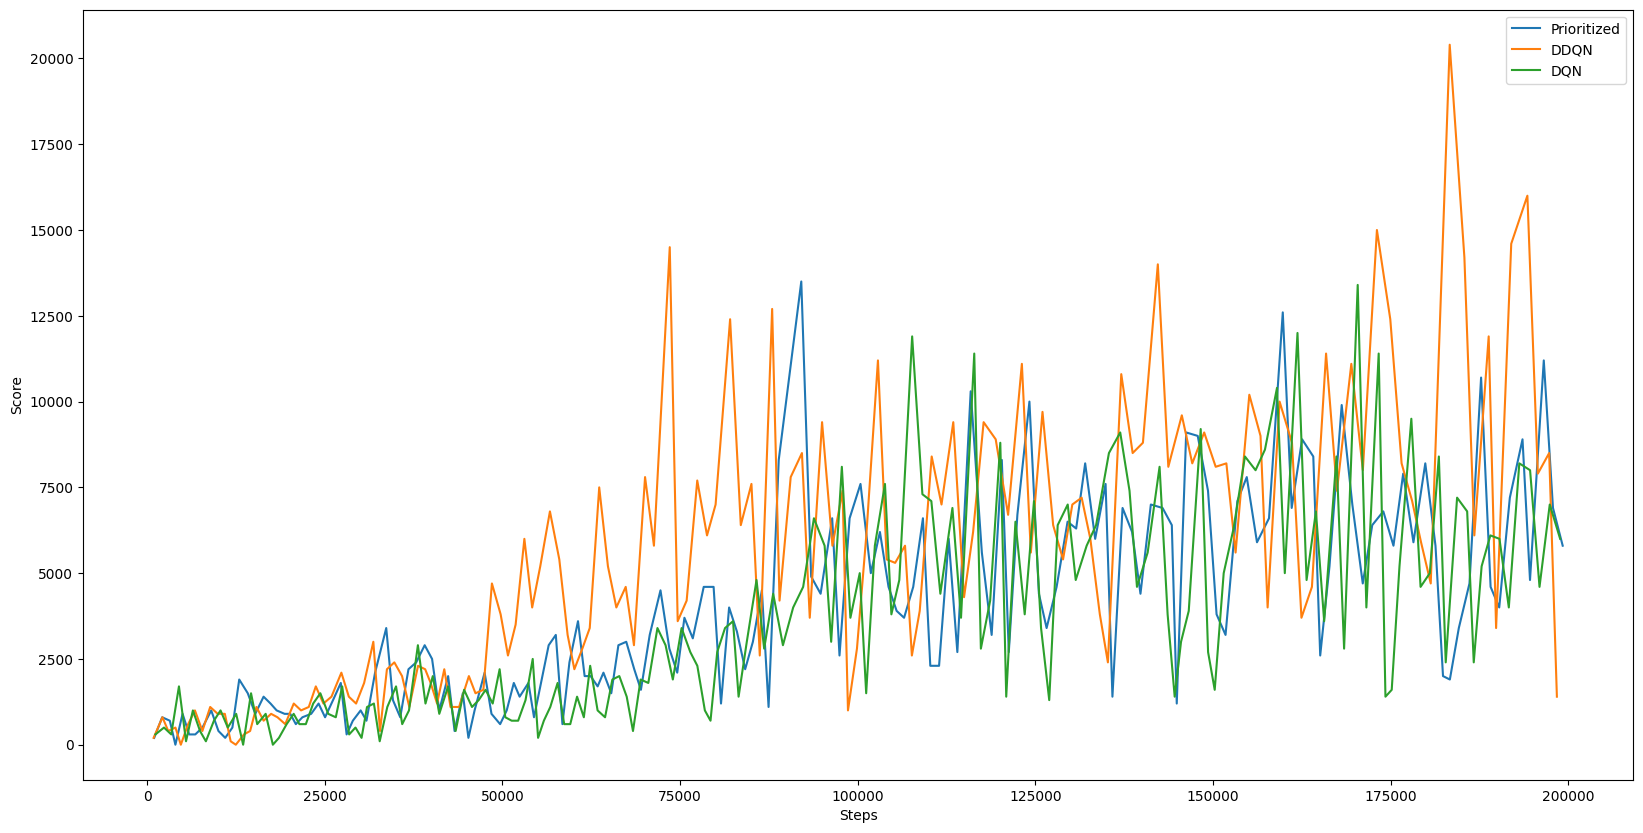

In [ ]:
rewards1 = np.load('/content/drive/MyDrive/RL/Report/Prioritized DDQN/all_rewards_v2.npy')
rewards2 = np.load('/content/drive/MyDrive/RL/Report/DDQN/all_rewards_v2.npy')
rewards3 = np.load('/content/drive/MyDrive/RL/Report/DQN/all_rewards_v2.npy')
plt.figure(figsize=(20,10))
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(rewards1[:, 0], rewards1[:, 1], label='Prioritized')
plt.plot(rewards2[:, 0], rewards2[:, 1], label='DDQN')
plt.plot(rewards3[:, 0], rewards3[:, 1], label='DQN')
plt.legend()

In [ ]:

env = gym.make("ALE/KungFuMaster-v5")
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0

model = torch.load('/content/drive/MyDrive/RL/Report/DDQN/model_v2.pth')
model.eval()


with torch.no_grad():
    while not done:
        state = preprocess(state)
        state = torch.tensor(state, dtype=torch.float32).to(device)
        q_values = model(state.unsqueeze(0))

        action = torch.argmax(q_values, dim=1)[0]

        action = action.detach().cpu().numpy()

        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
# env.play()

  logger.warn(



7600.0
